In [6]:
import os
new_directory = "/Users/huaxingzeng/Desktop/DATA 1030/DATA1030_Project/DATA1030_final_project"

# Change the current working directory
os.chdir(new_directory)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import shap
import xgboost
from xgboost import XGBRegressor

In [4]:
# Set display options to avoid truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Do not truncate column values
pd.set_option('display.width', 1000) 

In [7]:
# load data from a csv file
df_raw = pd.read_csv('StudentPerformanceFactors.csv')

print(df_raw.shape)

# Separate the feature matrix X and the target variable y
X = df_raw.drop(columns=['Exam_Score'])  # All columns except 'Exam_Score'
y = df_raw['Exam_Score']  # The target variable is 'Exam_Score'

# Now X contains the features and y contains the target
print('Feature matrix X:', X.shape)
print('Target variable y:', y.shape)

(6607, 20)
Feature matrix X: (6607, 19)
Target variable y: (6607,)


In [8]:
# generate X_other and the test set that we save for later use

# Create the stratification column based on Exam_Score >= 73
stratify_col = (df_raw['Exam_Score'] >= 73).astype(int)

# Step 1: Perform a stratified split based on the created column
X_other, X_test, y_other, y_test = train_test_split(
    X, y, 
    test_size = 0.2,  # Adjust test size as needed
    random_state = 42,  # Ensure reproducibility
    stratify = stratify_col  # Stratify based on the condition
)

print(X_other.shape)

(5285, 19)


In [9]:
# NEW version with NAs as a new catagory

# Replace blank cells with 'NA' in specific ordinal features
ordinal_ftrs = ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 'Family_Income', 
                'Teacher_Quality', 'Peer_Influence', 'Parental_Education_Level', 'Distance_from_Home']

X_other[ordinal_ftrs] = X_other[ordinal_ftrs].fillna('NA')
X_test[ordinal_ftrs] = X_test[ordinal_ftrs].fillna('NA')

# Update ordinal categories to include 'NA' where appropriate
ordinal_cats = [['Low', 'Medium', 'High'],  # Parental_Involvement
                ['Low', 'Medium', 'High'],  # Access_to_Resources
                ['Low', 'Medium', 'High'],  # Motivation_Level
                ['Low', 'Medium', 'High'],  # Family_Income
                ['NA', 'Low', 'Medium', 'High'],  # Teacher_Quality
                ['Negative', 'Neutral', 'Positive'],  # Peer_Influence
                ['NA', 'High School', 'College', 'Postgraduate'],  # Parental_Education_Level
                ['NA', 'Near', 'Moderate', 'Far']]  # Distance_from_Home

onehot_ftrs = ['Gender', 'Extracurricular_Activities', 'Internet_Access',
               'School_Type', 'Learning_Disabilities']

std_ftrs = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 
            'Physical_Activity','Tutoring_Sessions']

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_cats, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply preprocessing to test set for now
preprocessor.fit(X_other)

X_test_prep = clf.transform(X_test)

In [10]:
print(X_test_prep.shape)

(1322, 24)


In [23]:
def evaluate_model(X, y, preprocessor, models, param_grids, scoring='neg_root_mean_squared_error', n_splits=5, n_random_states=5):
    """
    Evaluate multiple models with preprocessing using Stratified K-Fold Cross-Validation for regression.
    After evaluation, train the best model on the full dataset.

    Parameters:
        X (pd.DataFrame): Feature dataset.
        y (pd.Series): Target variable.
        preprocessor (ColumnTransformer): Predefined preprocessing pipeline.
        models (dict): Dictionary with model names as keys and model instances as values.
        param_grids (dict): Dictionary with model names as keys and their respective hyperparameter grids as values.
        scoring (str): Scoring metric to optimize in GridSearchCV. Default is 'neg_root_mean_squared_error'.
        n_splits (int): Number of folds for Stratified K-Fold Cross-Validation. Default is 5.
        n_random_states (int): Number of different random states to use in the evaluation for averaging. Default is 5.

    Returns:
        pd.DataFrame: Results summary with average scores, standard deviation, and best parameters for each model.
        Pipeline: Final trained pipeline for the best model.
    """
    results = []
    best_model_pipeline = None
    best_score = np.inf if scoring == 'neg_root_mean_squared_error' else -np.inf
    
    # Create the stratification condition (Exam_Score >= 73)
    stratify_col = (y >= 73).astype(int)  # Convert to binary: 1 if Exam_Score >= 73 else 0
    
    # Initialize Stratified K-Fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Loop through each model
    for model_name, model_instance in models.items():
        param_grid = param_grids[model_name]
        
        # Initialize lists to store results for different random states
        model_scores = []
        model_std_devs = []
        
        # Loop through each random state
        for random_state in range(42, 42 + n_random_states):
            # Define pipeline including preprocessing and the model
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model_instance)
            ])
            
            # Grid search with Stratified K-Fold and a specific random state
            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                scoring=scoring,
                cv=skf.split(X, stratify_col),  # Use stratified splits based on the stratification condition
                n_jobs=-1,
                verbose=1
            )
            
            # Fit grid search for the current random state
            grid_search.fit(X, y)
            
            # Best model and its parameters
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            
            # Use cross_val_score to get the scores and calculate standard deviation for the current random state
            cv_scores = cross_val_score(best_model, X, y, cv=skf.split(X, stratify_col), scoring=scoring)
            
            # Calculate the mean and standard deviation of the scores
            mean_score = np.mean(cv_scores)
            std_dev = np.std(cv_scores)
            
            # Append the results for the current random state
            model_scores.append(mean_score)
            model_std_devs.append(std_dev)
        
        # After looping through all random states, calculate the average and std deviation of the scores
        avg_score = np.mean(model_scores)
        avg_std_dev = np.mean(model_std_devs)
        
        # Store results for this model
        results.append({
            'Model': model_name,
            'Average_Score': avg_score,
            'Avg_Std_Dev': avg_std_dev,
            'Best_Params': best_params
        })
        
        # Update best model if necessary
        if abs(avg_score) < abs(best_score):
            best_score = avg_score
            best_model_pipeline = grid_search.best_estimator_  # Store the best pipeline

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df, best_model_pipeline


In [ ]:
# Define regression models
models = {
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'RandomForest': RandomForestRegressor(),
    'SVR': SVR(),
    'XGBoost': XGBRegressor()
}

# Define hyperparameter grids for each model
param_grids = {
    'Lasso': {
        'model__alpha': [0.01, 0.1, 1, 10, 100]
    },
    'Ridge': {
        'model__alpha': [0.01, 0.1, 1, 10, 100]
    },
    'ElasticNet': {
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__l1_ratio': [0.1, 0.5, 0.7, 0.9]
    },
    'RandomForest': {
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'SVR': {
        'model__C': [0.1, 1, 10, 100],
        'model__epsilon': [0.01, 0.1, 1],
        'model__kernel': ['linear', 'rbf']
    },
    'XGBoost': {
        'model__n_estimators': [100, 200, 500],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [1, 3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0]
    }
}



# Use RMSE as the scoring metric
scoring = 'neg_root_mean_squared_error'

# Call the function to evaluate the models
results_df, best_model_pipeline = evaluate_model(
    X = X_other, 
    y = y_other, 
    preprocessor = preprocessor, 
    models = models, 
    param_grids = param_grids, 
    scoring = scoring, 
    n_splits = 5
)

print(results_df)

In [48]:
print(best_model_pipeline.named_steps['model'])

Ridge(alpha=10)


Train XGBoost for feature importance use

In [18]:
xgb_model = {
    'XGBoost': XGBRegressor()
}

xgb_param_grids = {

    'XGBoost': {
        'model__n_estimators': [200],
        'model__learning_rate': [0.1],
        'model__max_depth': [3],
        'model__subsample': [0.8]
    }
}

results_df_xgb, xgb_model_pipeline = evaluate_model(
    X = X_other, 
    y = y_other, 
    preprocessor = preprocessor, 
    models = xgb_model, 
    param_grids = xgb_param_grids, 
    scoring = scoring, 
    n_splits = 5
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RMSE Baseline

In [50]:
# RMSE for the baseline model: the RMSE if we predict everything as the mean of the target variable

mean_target = df_raw['Exam_Score'].mean()
baseline_predictions = np.full_like(df_raw['Exam_Score'], fill_value=mean_target)
baseline_rmse = np.sqrt(mean_squared_error(df_raw['Exam_Score'], baseline_predictions))

print(f"Baseline RMSE: {baseline_rmse}")

Baseline RMSE: 3.8972927232383934


In [40]:
# Step 3: Use the best model pipeline to predict on the test set
y_test_pred = best_model_pipeline.predict(X_test)

# Step 4: Calculate the error on the test set
test_score = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test RMSE: {test_score}')

Test RMSE: 1.7915219447050184


Global Feature Importance

In [ ]:
# Assuming you have the following variables:
# - best_model_pipeline: The trained pipeline returned from evaluate_model
# - X_test: Original test dataset (not preprocessed)
# - y_test: True labels for the test dataset

# Perform permutation importance
perm_importance = permutation_importance(
    best_model_pipeline,  # The pipeline including preprocessing and the trained model
    X_test,               # Original test features
    y_test,               # True target values
    n_repeats=10,         # Number of shuffles for each feature
    random_state=42,
    n_jobs=-1             # Parallelize computation
)

# Extract results into a DataFrame for better visualization
feature_names = X_test.columns  # Use the column names of the original dataset
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Importance': perm_importance.importances_mean,
    'Std_Dev': perm_importance.importances_std
}).sort_values(by='Mean_Importance', ascending=False)

# Display the top features
print(importance_df)


                       Feature  Mean_Importance   Std_Dev
1                   Attendance         0.729266  0.022468
0                Hours_Studied         0.428960  0.013926
6              Previous_Scores         0.066938  0.005338
3          Access_to_Resources         0.066889  0.005484
2         Parental_Involvement         0.060720  0.003117
9            Tutoring_Sessions         0.057314  0.004308
10               Family_Income         0.021092  0.002955
16    Parental_Education_Level         0.020402  0.002047
7             Motivation_Level         0.019762  0.001774
13              Peer_Influence         0.018768  0.002970
11             Teacher_Quality         0.013580  0.001699
17          Distance_from_Home         0.011477  0.001495
15       Learning_Disabilities         0.010573  0.001620
4   Extracurricular_Activities         0.010526  0.002014
8              Internet_Access         0.007097  0.001161
14           Physical_Activity         0.004194  0.001204
12            

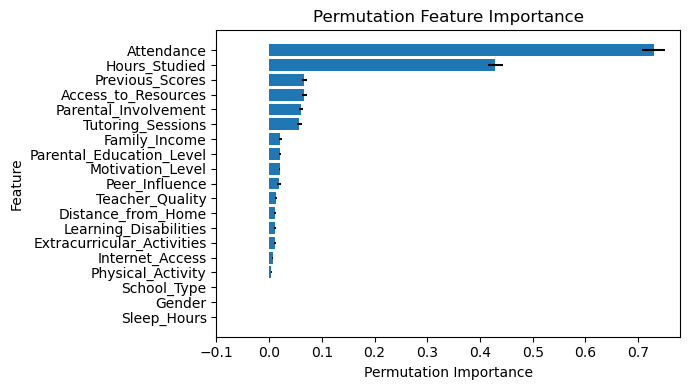

In [55]:
def plot_feature_importance(importance_df, title='Permutation Feature Importance', x_min=-0.25):
    """
    Plot feature importance scores with error bars for standard deviation and customize x-axis limits.

    Parameters:
        importance_df (pd.DataFrame): DataFrame with columns ['Feature', 'Mean_Importance', 'Std_Dev'].
        title (str): Title for the plot.
        x_min (float): Minimum value for the x-axis.
    """
    # Sort the DataFrame by importance scores
    importance_df = importance_df.sort_values(by='Mean_Importance', ascending=False)

    # Plot
    plt.figure(figsize=(7, 4))
    plt.barh(
        y=importance_df['Feature'], 
        width=importance_df['Mean_Importance'], 
        xerr=importance_df['Std_Dev'],  # Add error bars for standard deviation
        align='center'
    )
    plt.xlabel('Permutation Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.xlim(x_min, max(importance_df['Mean_Importance']) + 0.05)  # Set x-axis range
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
    plt.tight_layout()
    plt.show()

# Assuming you have an importance_df from earlier
plot_feature_importance(importance_df, x_min=-0.1)


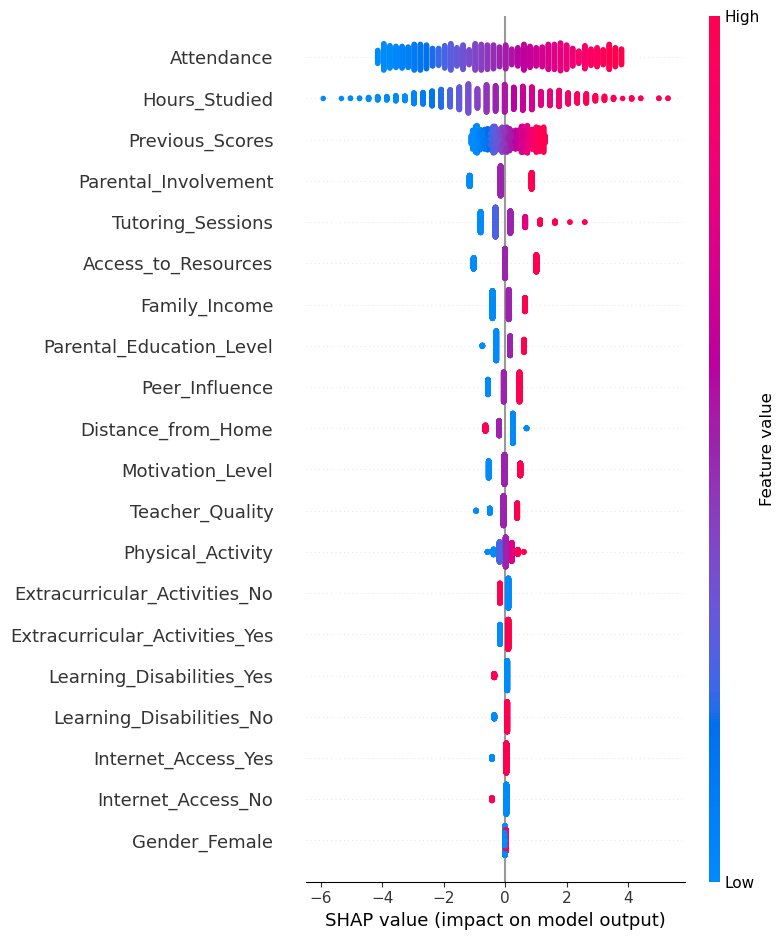

In [54]:
# Extract transformed features and feature names
def get_transformed_features_and_names(pipeline, X):
    """
    Transform the dataset using the pipeline and extract the feature names.

    Parameters:
        pipeline (Pipeline): Pretrained pipeline including preprocessing and the model.
        X (pd.DataFrame): Original feature dataset.

    Returns:
        X_transformed (np.ndarray): Transformed feature matrix.
        feature_names (list): Names of the transformed features.
    """
    # Transform the dataset
    preprocessor = pipeline.named_steps['preprocessor']
    X_transformed = preprocessor.transform(X)
    
    # Extract feature names from the preprocessor
    try:
        # If a ColumnTransformer is used
        feature_names = []
        for transformer_name, transformer, cols in preprocessor.transformers_:
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(cols))
            else:
                feature_names.extend(cols)
    except:
        # If feature names cannot be retrieved, fallback
        feature_names = [f'Feature_{i}' for i in range(X_transformed.shape[1])]
    
    return X_transformed, feature_names

# Step 1: Extract transformed features and feature names
X_test_transformed, feature_names = get_transformed_features_and_names(best_model_pipeline, X_test)

# Step 2: Create a SHAP explainer
model = best_model_pipeline.named_steps['model']
explainer = shap.Explainer(model, X_test_transformed)

# Step 3: Compute SHAP values
shap_values = explainer(X_test_transformed)

# Step 4: Generate the SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)


Generating SHAP force plot for index 0


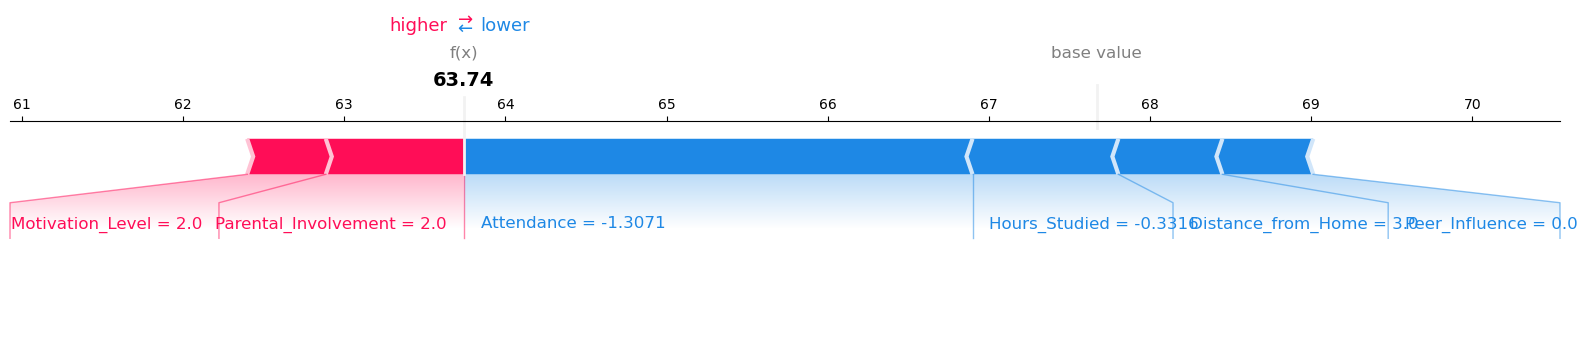

Generating SHAP force plot for index 100


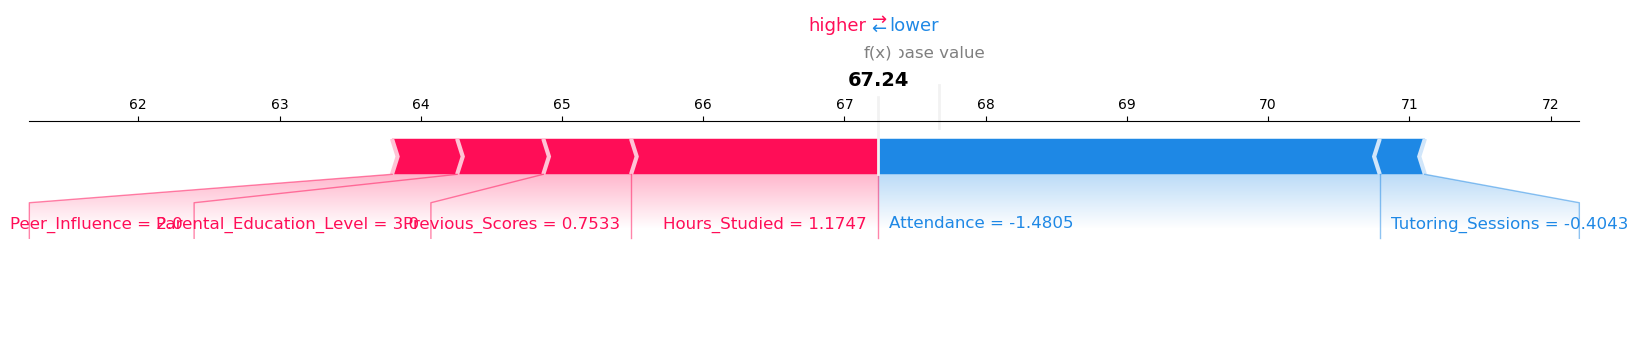

Generating SHAP force plot for index 200


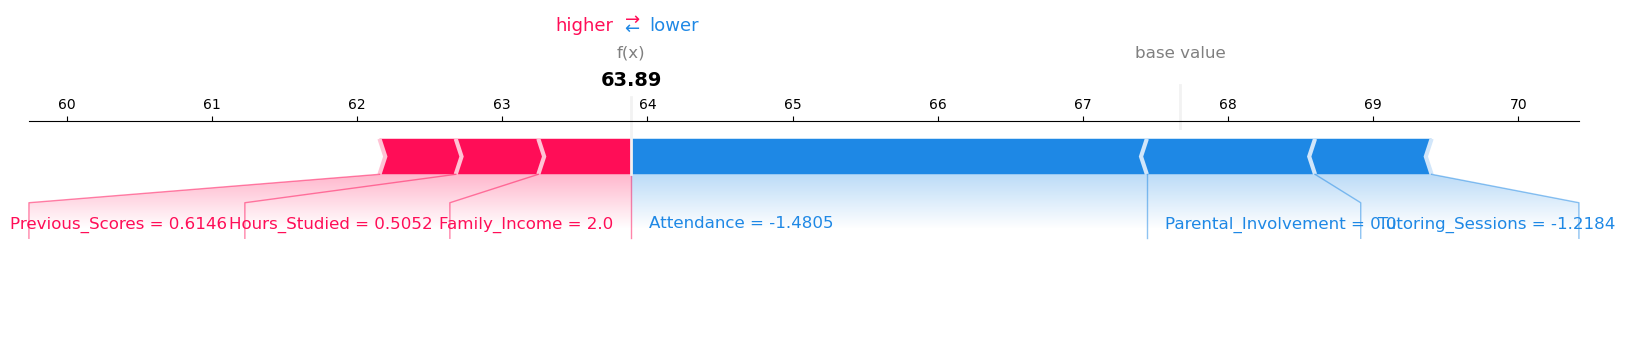

In [67]:
def generate_force_plot(shap_values, feature_names, index, X_transformed):
    """
    Generate and display a SHAP force plot for a specific index with only the
    top three most important features included, and values rounded to four decimal places.
    
    Parameters:
        shap_values (shap._explanation.Explanation): SHAP values for the dataset.
        feature_names (list): List of feature names after preprocessing.
        index (int): Index of the instance to visualize.
        X_transformed (np.ndarray): Transformed dataset.
    """
    # Extract SHAP values for the specified instance
    shap_value_instance = shap_values[index]
    
    # Round the SHAP values and features to 4 decimal places
    shap_vals_rounded = np.round(shap_value_instance.values, 4)
    features_rounded = np.round(X_transformed[index], 4)
    
    # Identify the top 3 features by absolute SHAP value
    top_indices = np.argsort(np.abs(shap_vals_rounded))[-6:]
    
    # Subset the SHAP values, features, and feature names to the top 3
    top_shap_vals = shap_vals_rounded[top_indices]
    top_features = features_rounded[top_indices]
    top_feature_names = [feature_names[i] for i in top_indices]
    
    # Generate and display the force plot with the top 3 features
    shap.force_plot(
        base_value=shap_value_instance.base_values,
        shap_values=top_shap_vals,
        features=top_features,
        feature_names=top_feature_names,
        matplotlib=True
    )

# Step 3: Generate force plots for indices 0, 100, and 200
indices_to_plot = [0, 100, 200]

for index in indices_to_plot:
    print(f"Generating SHAP force plot for index {index}")
    generate_force_plot(shap_values, feature_names, index, X_test_transformed)


In [ ]:
# function to get the transformed feature matrix and the feature names

def get_transformed_features_and_names(pipeline, X):
    """
    Transform the dataset using the pipeline and extract the feature names.

    Parameters:
        pipeline (Pipeline): Pretrained pipeline including preprocessing and the model.
        X (pd.DataFrame): Original feature dataset.

    Returns:
        X_transformed (np.ndarray): Transformed feature matrix.
        feature_names (list): Names of the transformed features.
    """
    # Transform the dataset
    preprocessor = pipeline.named_steps['preprocessor']
    X_transformed = preprocessor.transform(X)
    
    # Extract feature names from the preprocessor
    feature_names = []
    for transformer_name, transformer, cols in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(cols))
        else:
            feature_names.extend(cols)
    
    return X_transformed, feature_names


                          Feature     Importance
14                     Attendance  117749.023438
13                  Hours_Studied   76245.445312
16                Previous_Scores   15892.105469
0            Parental_Involvement   12002.176758
1             Access_to_Resources   11999.081055
18              Tutoring_Sessions    8883.589844
3                   Family_Income    4862.625000
5                  Peer_Influence    4058.222168
2                Motivation_Level    3530.278076
7              Distance_from_Home    3457.027100
6        Parental_Education_Level    3342.368652
4                 Teacher_Quality    2796.842285
12       Learning_Disabilities_No    2498.278809
17              Physical_Activity    2154.684326
9   Extracurricular_Activities_No    1991.018799
10             Internet_Access_No    1678.504272
15                    Sleep_Hours    1199.458008
8                   Gender_Female      67.854462
11            School_Type_Private      46.322098


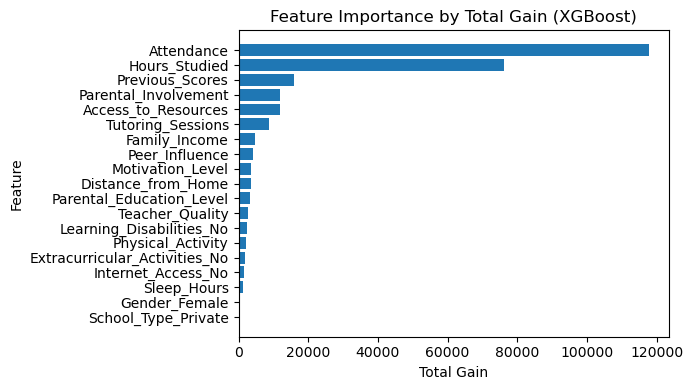

In [22]:
def measure_xgboost_feature_importance(xgb_model_pipeline, feature_names, importance_type='total_gain'):
    """
    Measure feature importance using XGBoost by the specified importance type (default: total gain).
    
    Parameters:
        best_pipeline (Pipeline): Trained pipeline containing an XGBRegressor model.
        feature_names (list): Names of the features in the dataset after preprocessing.
        importance_type (str): Type of feature importance to compute. Options: 'weight', 'gain', 'total_gain', 'cover', 'total_cover'.
    
    Returns:
        pd.DataFrame: Sorted DataFrame of feature importance scores.
    """
    # Extract the XGBoost model from the pipeline
    xgb_model = xgb_model_pipeline.named_steps['model']

    # Get feature importances using the specified importance type
    importance_scores = xgb_model.get_booster().get_score(importance_type=importance_type)
    
    # Map feature names to importance scores
    importance_df = pd.DataFrame({
        'Feature': [feature_names[int(key[1:])] for key in importance_scores.keys()],
        'Importance': importance_scores.values()
    }).sort_values(by='Importance', ascending=False)

    return importance_df

# Step 1: Retrieve feature names and the best pipeline from evaluate_model_with_xgboost
X_test_transformed, feature_names = get_transformed_features_and_names(xgb_model_pipeline, X_test)

# Step 2: Measure feature importance by total gain
importance_df = measure_xgboost_feature_importance(xgb_model_pipeline, feature_names, importance_type='total_gain')

# Step 3: Display the feature importance
print(importance_df)


plt.figure(figsize=(7, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.xlabel('Total Gain')
plt.ylabel('Feature')
plt.title('Feature Importance by Total Gain (XGBoost)')
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()
plt.show()


In [ ]:
print(results_df)

In [ ]:

# Example DataFrame based on the provided image
scores_df = pd.DataFrame({
    'Model': ['Lasso', 'Ridge', 'ElasticNet', 'RandomForest', 'SVR', 'XGBoost'],
    'Average_Score': [-2.088985, -2.088457, -2.088654, -2.389913, -2.089373, -2.131580],
    'Avg_Std_Dev': [0.246294, 0.245884, 0.246657, 0.217222, 0.242938, 0.206515]
})

# Extract models and their absolute RMSE scores
models = scores_df['Model']
rmse_scores = np.abs(scores_df['Average_Score'])

# Plot RMSE scores
plt.figure(figsize=(7, 4))
plt.bar(models, rmse_scores, color='skyblue', label='Model RMSE')
plt.axhline(y=baseline_rmse, color='red', linestyle='--', label='Baseline RMSE')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparison of Model RMSE with Baseline RMSE')
plt.legend()
plt.show()


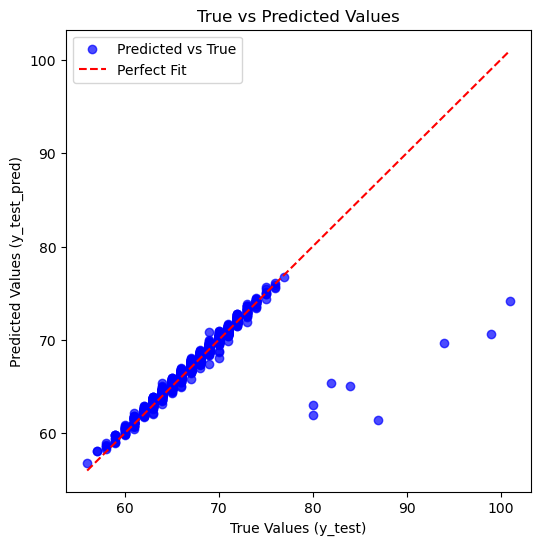

In [42]:
# Assuming `y_test` contains the true values and `y_test_pred` contains the predicted values
plt.figure(figsize=(6, 6))

# Scatter plot of true vs predicted values
plt.scatter(y_test, y_test_pred, alpha=0.7, label='Predicted vs True', color='blue')

# Add a diagonal line representing perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')

# Add labels, title, and legend
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_test_pred)')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()


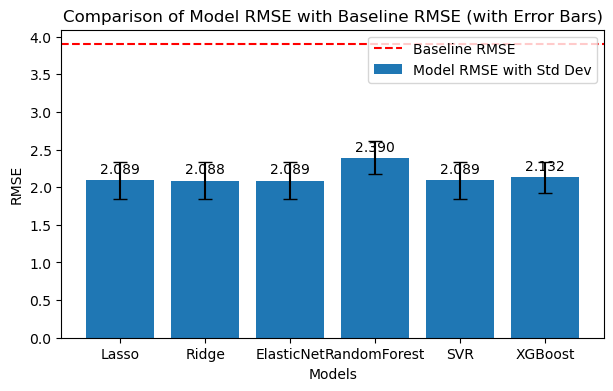

In [52]:
# Example DataFrame based on the image
scores_df = pd.DataFrame({
    'Model': ['Lasso', 'Ridge', 'ElasticNet', 'RandomForest', 'SVR', 'XGBoost'],
    'Average_Score': [-2.088985, -2.088457, -2.088654, -2.389913, -2.089373, -2.131580],
    'Avg_Std_Dev': [0.246294, 0.245884, 0.246657, 0.217222, 0.242938, 0.206515]
})

# Extract models and their absolute RMSE scores
models = scores_df['Model']
rmse_scores = np.abs(scores_df['Average_Score'])

# Plot RMSE scores with standard deviation as error bars
plt.figure(figsize=(7, 4))
bars = plt.bar(models, rmse_scores, yerr=scores_df['Avg_Std_Dev'], capsize=5, label='Model RMSE with Std Dev')
plt.axhline(y=baseline_rmse, color='red', linestyle='--', label='Baseline RMSE')

# Add labels to bars
for bar, value in zip(bars, rmse_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparison of Model RMSE with Baseline RMSE (with Error Bars)')
plt.legend()
plt.show()


In [ ]:
import pickle

# Define the file path
file_path = "/Users/huaxingzeng/Desktop/Final_final_project/best_model.save"

# Save the best model
with open(file_path, 'wb') as file:
    pickle.dump(best_model_pipeline, file)

print(f"Best model saved to {file_path}")
